In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import re
import numpy as np
import plotly as plt
import seaborn as sns
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
file = pd.read_csv('/content/drive/MyDrive/BA/Tweets.csv')

In [5]:
df = pd.DataFrame(file)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
new_df = df[df['airline'] == 'United']
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3822 entries, 504 to 4325
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      3822 non-null   int64  
 1   airline_sentiment             3822 non-null   object 
 2   airline_sentiment_confidence  3822 non-null   float64
 3   negativereason                2633 non-null   object 
 4   negativereason_confidence     3000 non-null   float64
 5   airline                       3822 non-null   object 
 6   airline_sentiment_gold        8 non-null      object 
 7   name                          3822 non-null   object 
 8   negativereason_gold           7 non-null      object 
 9   retweet_count                 3822 non-null   int64  
 10  text                          3822 non-null   object 
 11  tweet_coord                   319 non-null    object 
 12  tweet_created                 3822 non-null   object 
 13  t

In [8]:
new_df.drop(['airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'], axis=1)
new_order = ['text', 'airline_sentiment']
data = new_df[new_order]
data.head(10)

,text,airline_sentiment
504,@united thanks,positive
505,@united Thanks for taking care of that MR!! Ha...,positive
506,@united still no refund or word via DM. Please...,negative
507,@united Delayed due to lack of crew and now de...,negative
508,@united thanks -- we filled it out. How's our ...,positive
509,@united Your ERI-ORD express connections are h...,negative
510,@united even on international flight Glasgow t...,neutral
511,@united you think you boarded flight AU1066 to...,negative
512,"@united I understand, but it's tough when ther...",neutral
513,@united Gate agent hooked me up with alternate...,negative


In [9]:
data['airline_sentiment'].value_counts()

negative    2633
neutral      697
positive     492
Name: airline_sentiment, dtype: int64

In [11]:
class_counts = data['airline_sentiment'].value_counts()
neg = class_counts.get('negative', 0)
neu = class_counts.get('neutral', 0)
pos = class_counts.get('positive', 0)
dist = [
    graph_objs.Bar(
        x=["negative","neutral","positive"],
        y=[neg, neu, pos],
)]
plt.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Sentiment type distribution in training set")})

Pre-processing

In [46]:
def remove_emojis(tweets):
   emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
   tweets.loc[:, "text"].replace(emoji_pattern, "", inplace=True)
   return tweets
def remove_urls(tweets):
        tweets.loc[:, "text"] = tweets["text"].apply(lambda x: re.sub(r"http\S+", "", x))
        return tweets
def remove_na(tweets):
        return tweets[tweets["text"] != "Not Available"]
def remove_special_chars(tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'", "+"
                                                                     "--", "---", "#"]):
            tweets.loc[:, "text"].replace(remove, "", inplace=True)
        return tweets
def remove_usernames(tweets):
        tweets.loc[:, "text"].replace(re.compile(r"@[^\s]+[\s]?"), "", inplace=True)
        return tweets
def remove_numbers(tweets):
        tweets.loc[:, "text"] = tweets["text"].apply(lambda x: ''.join([c for c in x if not c.isdigit()]))
        return tweets

In [47]:
def clean_data(text):
  text = remove_emojis(text)
  text = remove_urls(text)
  text = remove_na(text)
  text = remove_special_chars(text)
  text = remove_usernames(text)
  text = remove_numbers(text)
  return text

In [48]:
processed_data = clean_data(data)
processed_data.head(10)

<ipython-input-46-456951aa4a23>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-456951aa4a23>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,text,airline_sentiment
504,united thanks,positive
505,united Thanks for taking care of that MR Happy...,positive
506,united still no refund or word via DM Please r...,negative
507,united Delayed due to lack of crew and now del...,negative
508,united thanks we filled it out Hows our luck ...,positive
509,united Your ERIORD express connections are hug...,negative
510,united even on international flight Glasgow to...,neutral
511,united you think you boarded flight AU too ear...,negative
512,united I understand but its tough when there i...,neutral
513,united Gate agent hooked me up with alternate ...,negative


Tokenize

In [49]:
def tokenize(data, tokenizer=nltk.word_tokenize):
        new_value = []
        for text in data['text'].to_list():
            text = tokenizer(text.lower())
            new_value.append(text)
        data["text"] = new_value
        return data

In [50]:
processed_data = tokenize(processed_data)
processed_data.head(10)

,text,airline_sentiment
504,"[united, thanks]",positive
505,"[united, thanks, for, taking, care, of, that, ...",positive
506,"[united, still, no, refund, or, word, via, dm,...",negative
507,"[united, delayed, due, to, lack, of, crew, and...",negative
508,"[united, thanks, we, filled, it, out, hows, ou...",positive
509,"[united, your, eriord, express, connections, a...",negative
510,"[united, even, on, international, flight, glas...",neutral
511,"[united, you, think, you, boarded, flight, au,...",negative
512,"[united, i, understand, but, its, tough, when,...",neutral
513,"[united, gate, agent, hooked, me, up, with, al...",negative


In [51]:
words = Counter()
for idx in processed_data.index:
    words.update(processed_data.loc[idx, "text"])
words.most_common(5)

[('united', 4082), ('to', 2244), ('the', 1687), ('i', 1349), ('a', 1289)]

In [52]:
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(10)

[('united', 4082),
 ('flight', 1000),
 ('not', 479),
 ('get', 327),
 ('thanks', 274),
 ('service', 274),
 ('time', 227),
 ('ua', 221),
 ('customer', 218),
 ('im', 218)]

In [53]:
wordlist = [k for k, v in words.most_common()]
wordlist

['united',
 'flight',
 'not',
 'get',
 'thanks',
 'service',
 'time',
 'ua',
 'customer',
 'im',
 'bag',
 'cancelled',
 'plane',
 'delayed',
 'help',
 'gate',
 'would',
 'amp',
 'flights',
 'one',
 'still',
 'us',
 'thank',
 'hours',
 'dont',
 'late',
 'please',
 'like',
 'back',
 'airline',
 'cant',
 'hour',
 'need',
 'got',
 'waiting',
 'last',
 'make',
 'delay',
 'bags',
 'airport',
 'never',
 'day',
 'today',
 'dm',
 'lost',
 'flightled',
 'u',
 'way',
 'seat',
 'wait',
 'first',
 'know',
 'yes',
 'fly',
 'going',
 'people',
 'worst',
 'really',
 'thats',
 'crew',
 'luggage',
 'good',
 'agent',
 'seats',
 'baggage',
 'check',
 'ticket',
 'due',
 'even',
 'go',
 'trying',
 'staff',
 'ever',
 'flying',
 'see',
 'min',
 'sent',
 'another',
 'take',
 'hrs',
 'number',
 'told',
 'home',
 'days',
 'great',
 'email',
 'getting',
 'want',
 'phone',
 'ord',
 'let',
 'call',
 'made',
 'problems',
 'care',
 'minutes',
 'sure',
 'guys',
 'two',
 'connection',
 'ewr',
 'ive',
 'new',
 'didnt',


In [54]:
def build_data_model(data, wordlist):
        label_column = ["label"]
        columns = label_column + list(
            map(lambda w: w + "_bow",wordlist))
        labels = []
        rows = []
        for idx in data.index:
            current_row = []
            current_label = data.loc[idx, "airline_sentiment"]
            labels.append(current_label)
            current_row.append(current_label)

            # add bag-of-words
            tokens = set(data.loc[idx, "text"])
            for _, word in enumerate(wordlist):
                current_row.append(1 if word in tokens else 0)
            rows.append(current_row)
        data_model = pd.DataFrame(rows, columns=columns)
        data_labels = pd.Series(labels)
        return data_model, data_labels

In [55]:
data_model, data_labels = build_data_model(processed_data, wordlist)
print(data_model.head())

      label  united_bow  flight_bow  not_bow  get_bow  thanks_bow  \
0  positive           1           0        0        0           1   
1  positive           1           0        0        0           1   
2  negative           1           1        0        0           0   
3  negative           1           0        0        0           0   
4  positive           1           0        0        0           1   

   service_bow  time_bow  ua_bow  customer_bow  ...  crâpe_bow  biscuits_bow  \
0            0         0       0             0  ...          0             0   
1            0         0       0             1  ...          0             0   
2            0         0       0             0  ...          0             0   
3            1         0       0             0  ...          0             0   
4            0         0       0             0  ...          0             0   

   sentimental_bow  heartbroken_bow  mp_bow  flightsairports_bow  \
0                0                0 

In [56]:
grouped = data_model.groupby(["label"]).sum()
words_to_visualize = []
sentiments = ["positive","negative","neutral"]
#get the most 7 common words for every sentiment
for sentiment in sentiments:
    words = grouped.loc[sentiment,:]
    words.sort_values(inplace=True,ascending=False)
    for w in words.index[:7]:
        if w not in words_to_visualize:
            words_to_visualize.append(w)


#visualize it
plot_data = []
for sentiment in sentiments:
    plot_data.append(graph_objs.Bar(
            x = [w.split("_")[0] for w in words_to_visualize],
            y = [grouped.loc[sentiment,w] for w in words_to_visualize],
            name = sentiment
    ))

plt.offline.iplot({
        "data":plot_data,
        "layout":graph_objs.Layout(title="Most common words across sentiments")
    })

In [57]:
import random
seed = 666
random.seed(seed)

In [58]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    log("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    # huấn luyện mô hình
    model = classifier
    model.fit(X_train,y_train)
    log("Learing time {0}s".format(time() - now))
    now = time()
    # dự đoán kết quả trên tập test
    predictions = model.predict(X_test)
    log("Predicting time {0}s".format(time() - now))
    # tính toán các độ đo precision, recall, accuracy
    precision = precision_score(y_test, predictions, average= None)
    recall = recall_score(y_test, predictions, average= None)
    accuracy = accuracy_score(y_test, predictions,)
    f1 = f1_score(y_test, predictions, average= None)
    log("=================== Results ===================")
    log("            Negative     Neutral     Positive")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1, predictions

def log(x):
    #can be used to write to log file
    print(x)

In [59]:
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(data_model.iloc[:, 1:], data_model.iloc[:, 0],
                                                    train_size=0.8, stratify=data_model.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1, y_pred = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())


Testing BernoulliNB
Learing time 0.21819424629211426s
Predicting time 0.08467364311218262s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.82390438 0.2183908  0.05940594]
Precision[0.71016484 0.55882353 1.        ]
Recall   [0.98102467 0.13571429 0.03061224]
Accuracy 0.7045751633986929


In [60]:
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(data_model.iloc[:, 1:], data_model.iloc[:, 0],
                                                    train_size=0.8, stratify=data_model.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1, y_pred = test_classifier(X_train, y_train, X_test, y_test, GaussianNB())


Testing GaussianNB
Learing time 0.236191987991333s
Predicting time 0.07314705848693848s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.7687747  0.33454545 0.37860082]
Precision[0.80206186 0.34074074 0.31724138]
Recall   [0.73814042 0.32857143 0.46938776]
Accuracy 0.6287581699346405


In [61]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(data_model.iloc[:, 1:], data_model.iloc[:, 0],
                                                    train_size=0.8, stratify=data_model.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1, y_pred = test_classifier(X_train, y_train, X_test, y_test, MultinomialNB())


Testing MultinomialNB
Learing time 0.08778834342956543s
Predicting time 0.04731011390686035s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.8554007  0.42290749 0.52903226]
Precision[0.79066023 0.55172414 0.71929825]
Recall   [0.9316888  0.34285714 0.41836735]
Accuracy 0.7581699346405228


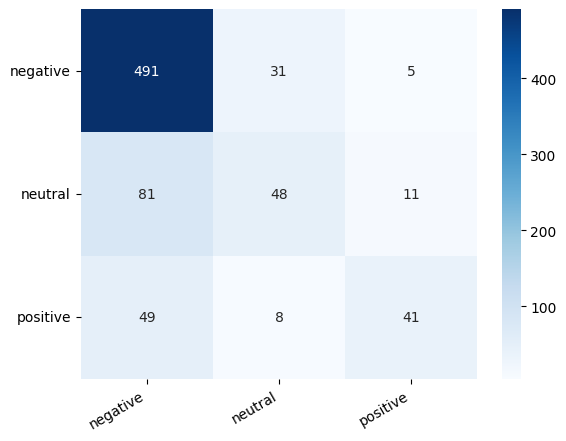

In [62]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive'])
show_confusion_matrix(df_cm)

In [63]:
bow_columns = X_test.columns.difference(['sentence'])
X_test['sentence'] = X_test[bow_columns].apply(lambda row: ' '.join([word * count for word, count in row.items() if count == 1]), axis=1)
X_test['sentence']

2486    cities_bow disappointed_bow doesnt_bow flight_...
202     another_bow calling_bow claim_bow filed_bow iv...
577                            go_bow hell_bow united_bow
674     appear_bow dm_bow dont_bow english_bow ill_bow...
960     +_bow customer_bow delay_bow disservice_bow du...
                              ...                        
2645    bad_bow flight_bow handling_bow hours_bow orig...
834     back_bow basically_bow evening_bow flight_bow ...
3683    asks_bow customer_bow customersyou_bow learn_b...
785                              hilarious_bow united_bow
840     able_bow awesome_bow care_bow get_bow help_bow...
Name: sentence, Length: 765, dtype: object

In [ ]:
df = pd.DataFrame({'text': X_test['sentence'], 'y_pred': y_pred, 'y_true': y_test})
fillter_df = df[df['y_pred'] != df['y_true']]
text = fillter_df.text.to_list()
new = []
for i in text:
  new.append(i.replace('_bow', ''))
new

In [76]:
wrong_label = [[x, y, z] for x, y, z in zip(new, fillter_df['y_pred'].tolist(), fillter_df['y_true'].tolist())]
wrong_label

[['another calling claim filed ive united updates way', 'negative', 'neutral'],
 ['airport attendant delays everyone gate multiple newark nicest pleasant right still united',
  'negative',
  'positive'],
 ['flightaware lol number per tail thanks ua united us wait',
  'negative',
  'positive'],
 ['control emails informed keeping think united worries ’',
  'negative',
  'neutral'],
 ['thank united', 'positive', 'neutral'],
 ['book fly minor need one order two unaccompanied united ways',
  'negative',
  'neutral'],
 ['appreciate bag care following matter received taking united',
  'negative',
  'positive'],
 ['acceptable better creative meals nonvegan noodles not peas united vegan yogurt zukes',
  'neutral',
  'negative'],
 ['got thanks united', 'negative', 'positive'],
 ['amp cyndi give gold star troy united', 'negative', 'positive'],
 ['brotha going guys help lol miles restructured silver status thought today united winning',
  'neutral',
  'negative'],
 ['brian complaint edit includes 